# Rain Prediction using Logistic Regression and K-NN

<h2>Introduction</h2>

<b>Logistic Regression</b> is machine learning classification algorithm which predict probability of categorical dependent variable. Logistic regression have the same concept with Linear regression, the different is Logistic Regression (Logit) used to predict observations to a discrete set of classes, whilst Linear Regression used to predict continous set of classes.<br>
Generally,  Logistic Regression is used when the dependent variable(target) is categorical. Given ilustration below:<br>
<img src="Capture.JPG" width="500" /><br>
In this notebook, I implement Logistic Regression to predict whether tomorrow will rain or not in Australia by training a binary classification model.

<h2>Data Preparation</h2>

<h4>Import library</h4>

In [153]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, recall_score, classification_report
import statsmodels.api as sm
%matplotlib inline
import warnings

warnings.filterwarnings('ignore')

pd.set_option('display.float_format', lambda x: '%.3f' % x)

<h4>Read the data</h4>

In [154]:
data = pd.read_csv('data_input/weatherAUS.csv')

In [155]:
data.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RISK_MM,RainTomorrow
0,2008-12-01,Albury,13.400,22.900,0.600,nan,nan,W,44.000,W,...,22.000,1007.700,1007.100,8.000,nan,16.900,21.800,No,0.000,No
1,2008-12-02,Albury,7.400,25.100,0.000,nan,nan,WNW,44.000,NNW,...,25.000,1010.600,1007.800,nan,nan,17.200,24.300,No,0.000,No
2,2008-12-03,Albury,12.900,25.700,0.000,nan,nan,WSW,46.000,W,...,30.000,1007.600,1008.700,nan,2.000,21.000,23.200,No,0.000,No
3,2008-12-04,Albury,9.200,28.000,0.000,nan,nan,NE,24.000,SE,...,16.000,1017.600,1012.800,nan,nan,18.100,26.500,No,1.000,No
4,2008-12-05,Albury,17.500,32.300,1.000,nan,nan,W,41.000,ENE,...,33.000,1010.800,1006.000,7.000,8.000,17.800,29.700,No,0.200,No


In [156]:
data.shape

(142193, 24)

<h4>Variable description</h4>

`Date`: The date of observation<br>
`Location`: The common name of the location of the weather station<br>
`MinTemp`: The minimum temperature in degrees celsius<br>
`MaxTemp`: The maximum temperature in degrees celsius<br>
`Rainfall`: The amount of rainfall recorded for the day in mm<br>
`Evaporation`: The so-called Class A pan evaporation (mm) in the 24 hours to 9am<br>
`Sunshine`: The number of hours of bright sunshine in the day.<br>
`WindGustDir`: The direction of the strongest wind gust in the 24 hours to midnight<br>
`WindGustSpeed`: The speed (km/h) of the strongest wind gust in the 24 hours to midnight<br>
`WindDir9am`: Direction of the wind at 9am<br>
`WinDir3pm`: Direction of the wind at 3pm<br>
`WindSpeed9am`: Wind speed (km/hr) averaged over 10 minutes prior to 9am<br>
`WindSpeed3pm`: Wind speed (km/hr) averaged over 10 minutes prior to 3pm<br>
`Humidity9am`: Humidity (percent) at 9am<br>
`Humidity3pm`: Humidity (percent) at 3pm<br>
`Pressure9am`: Atmospheric pressure (hpa) reduced to mean sea level at 9am<br>
`Pressure3pm`: Atmospheric pressure (hpa) reduced to mean sea level at 3pm<br>
`Cloud9am`: Fraction of sky obscured by cloud at 9am<br>
`Cloud3pm`: Fraction of sky obscured by cloud at 3pm<br>
`Temp9am`: Temperature (degrees C) at 9am<br>
`Temp3pm`: Temperature (degrees C) at 3pm<br>
`RainToday`: Whether today rain or not<br>
`RISK_MM`: The amount of next day rain in mm. Used to create response variable RainTomorrow. <br>
`RainTomorrow`: The target variable. Did it rain tomorrow?

In [157]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 142193 entries, 0 to 142192
Data columns (total 24 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Date           142193 non-null  object 
 1   Location       142193 non-null  object 
 2   MinTemp        141556 non-null  float64
 3   MaxTemp        141871 non-null  float64
 4   Rainfall       140787 non-null  float64
 5   Evaporation    81350 non-null   float64
 6   Sunshine       74377 non-null   float64
 7   WindGustDir    132863 non-null  object 
 8   WindGustSpeed  132923 non-null  float64
 9   WindDir9am     132180 non-null  object 
 10  WindDir3pm     138415 non-null  object 
 11  WindSpeed9am   140845 non-null  float64
 12  WindSpeed3pm   139563 non-null  float64
 13  Humidity9am    140419 non-null  float64
 14  Humidity3pm    138583 non-null  float64
 15  Pressure9am    128179 non-null  float64
 16  Pressure3pm    128212 non-null  float64
 17  Cloud9am       88536 non-null

<h4>Drop unused variables</h4>

In this steps, there are several variable need to removed :<br>
1. Location : location is categorical variable which contains 49 levels, including it in the model will increase complexcity of the models and lead to model overfit.<br> 
2. Risk_MM : Risk_MM determine whether or not it rained to create the binary target. Since it contains information directly about the target variable, including it would leak the future information to the model<br>
3. Date : date is represent date of observation, based on business case this variable contains less information to predict the target variable.


In [158]:
data.drop(['Location','RISK_MM','Date'], axis=1, inplace=True)

<h3>Working with Categorical Data</h3>

<h4>Fill missing value in categorical data with wording 'unknown'</h4>

In [159]:
data[['WindGustDir','WindDir9am','WindDir3pm','RainToday']] = \
data[['WindGustDir','WindDir9am','WindDir3pm','RainToday']].fillna('unknown')

<h4>Change Data Types</h4>

In [160]:
data[['WindGustDir','WindDir9am','WindDir3pm','RainToday','RainTomorrow']] = \
data[['WindGustDir','WindDir9am','WindDir3pm','RainToday','RainTomorrow']].astype('category')

<h4>Check categorical level</h4>

In [161]:
categorical = data[['WindGustDir','WindDir9am','WindDir3pm','RainToday','RainTomorrow']]

In [162]:
for var in categorical:
    print(var,'contains',len(data[var].unique()), ' labels')

WindGustDir contains 17  labels
WindDir9am contains 17  labels
WindDir3pm contains 17  labels
RainToday contains 3  labels
RainTomorrow contains 2  labels


<h3>Working with Numerical Data</h3>

In [163]:
numerical = data.select_dtypes(include='number')

In [164]:
numerical.describe()

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm
count,141556.000,141871.000,140787.000,81350.000,74377.000,132923.000,140845.000,139563.000,140419.000,138583.000,128179.000,128212.000,88536.000,85099.000,141289.000,139467.000
mean,12.186,23.227,2.350,5.470,7.625,39.984,14.002,18.638,68.844,51.483,1017.654,1015.258,4.437,4.503,16.988,21.687
std,6.403,7.118,8.465,4.189,3.782,13.589,8.893,8.803,19.051,20.798,7.105,7.037,2.887,2.721,6.493,6.938
min,-8.500,-4.800,0.000,0.000,0.000,6.000,0.000,0.000,0.000,0.000,980.500,977.100,0.000,0.000,-7.200,-5.400
25%,7.600,17.900,0.000,2.600,4.900,31.000,7.000,13.000,57.000,37.000,1012.900,1010.400,1.000,2.000,12.300,16.600
50%,12.000,22.600,0.000,4.800,8.500,39.000,13.000,19.000,70.000,52.000,1017.600,1015.200,5.000,5.000,16.700,21.100
75%,16.800,28.200,0.800,7.400,10.600,48.000,19.000,24.000,83.000,66.000,1022.400,1020.000,7.000,7.000,21.600,26.400
max,33.900,48.100,371.000,145.000,14.500,135.000,130.000,87.000,100.000,100.000,1041.000,1039.600,9.000,9.000,40.200,46.700


In [165]:
numerical.isna().sum()/len(data)

MinTemp         0.004
MaxTemp         0.002
Rainfall        0.010
Evaporation     0.428
Sunshine        0.477
WindGustSpeed   0.065
WindSpeed9am    0.009
WindSpeed3pm    0.018
Humidity9am     0.012
Humidity3pm     0.025
Pressure9am     0.099
Pressure3pm     0.098
Cloud9am        0.377
Cloud3pm        0.402
Temp9am         0.006
Temp3pm         0.019
dtype: float64

<h4>Delete columns which contains missing value about 40% from data length </h4>

In [166]:
data.drop(['Evaporation','Sunshine','Cloud3pm'], axis=1, inplace=True)

Text(0.5, 1.0, '')

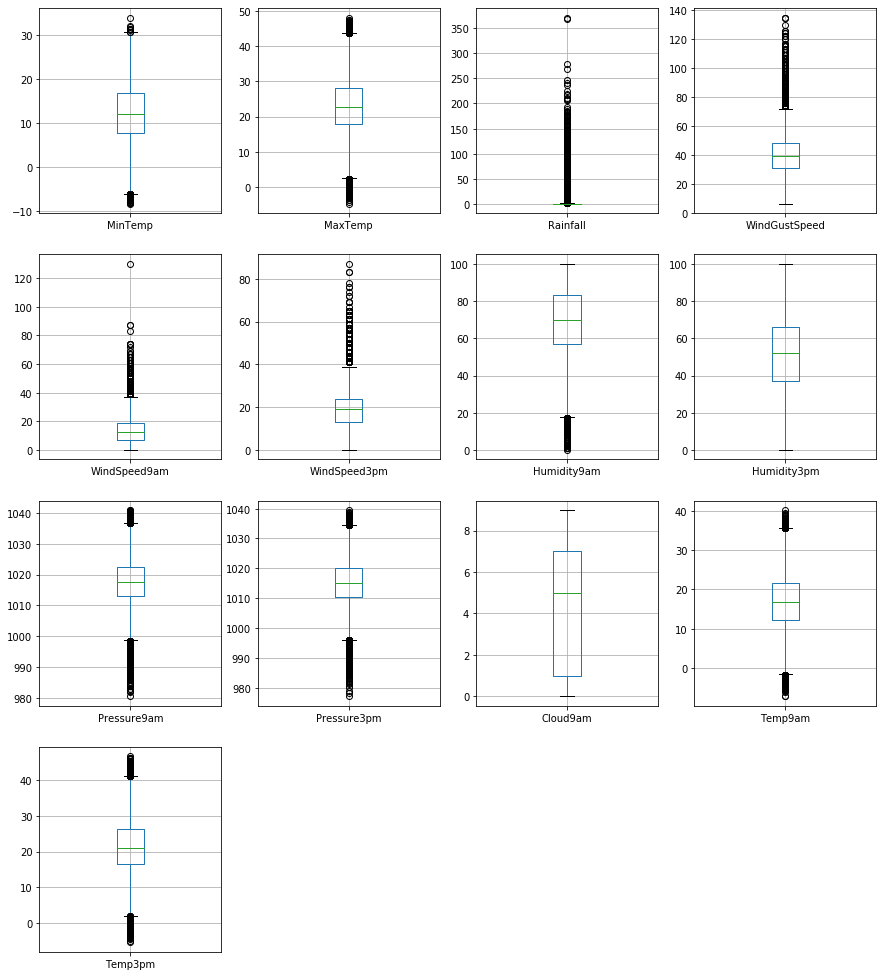

In [167]:
plt.figure(figsize=(15,40))

plt.subplot(9, 4, 1)
fig = data.boxplot(column='MinTemp')
fig.set_title('')

plt.subplot(9, 4, 2)
fig = data.boxplot(column='MaxTemp')
fig.set_title('')

plt.subplot(9, 4, 3)
fig = data.boxplot(column='Rainfall')
fig.set_title('')

plt.subplot(9, 4, 4)
fig = data.boxplot(column='WindGustSpeed')
fig.set_title('')

plt.subplot(9, 4, 5)
fig = data.boxplot(column='WindSpeed9am')
fig.set_title('')

plt.subplot(9, 4, 6)
fig = data.boxplot(column='WindSpeed3pm')
fig.set_title('')

plt.subplot(9, 4, 7)
fig = data.boxplot(column='Humidity9am')
fig.set_title('')

plt.subplot(9, 4, 8)
fig = data.boxplot(column='Humidity3pm')
fig.set_title('')

plt.subplot(9, 4, 9)
fig = data.boxplot(column='Pressure9am')
fig.set_title('')

plt.subplot(9, 4, 10)
fig = data.boxplot(column='Pressure3pm')
fig.set_title('')

plt.subplot(9, 4, 11)
fig = data.boxplot(column='Cloud9am')
fig.set_title('')

plt.subplot(9, 4, 12)
fig = data.boxplot(column='Temp9am')
fig.set_title('')

plt.subplot(9, 4, 13)
fig = data.boxplot(column='Temp3pm')
fig.set_title('')

<h4>Impute missing value</h4>

In [168]:
med_ = data[['MinTemp','MaxTemp','Rainfall','WindGustSpeed','WindSpeed9am','WindSpeed3pm','Humidity9am','Pressure9am',\
             'Pressure3pm','Temp9am','Temp3pm']]
men_ = data[['Humidity3pm','Cloud9am']]

In [169]:
for col in med_:
    col_median=data[col].median()
    data[col].fillna(col_median, inplace=True)
for col_ in men_:
    col_mean=data[col_].mean()
    data[col_].fillna(col_mean,inplace=True)

<h4>Remove outliers</h4>

In [170]:
Q1 = numerical.quantile(0.25)
Q3 = numerical.quantile(0.75)
IQR = Q3 - Q1

In [171]:
#count of outliers
((numerical < (Q1 - 1.5 * IQR)) | (numerical > (Q3 + 1.5 * IQR))).sum()

MinTemp             62
MaxTemp            459
Rainfall         25228
Evaporation       1954
Sunshine             0
WindGustSpeed     3006
WindSpeed9am      1739
WindSpeed3pm      2458
Humidity9am       1419
Humidity3pm          0
Pressure9am       1174
Pressure3pm        906
Cloud9am             0
Cloud3pm             0
Temp9am            247
Temp3pm            735
dtype: int64

In [172]:
data_wo_outliers = data[~((numerical < (Q1 - 1.5 * IQR)) |(numerical > (Q3 + 1.5 * IQR))).any(axis=1)]
data_wo_outliers.shape

(109459, 18)

<h2>Exploratory Data Analysis</h2>

<h4>Check proportion of categorical predictor to targeted class</h4>

To avoid perfect separation between predictor categorical variable and target variable, we must check proportion of categorical predictor to targeted class.

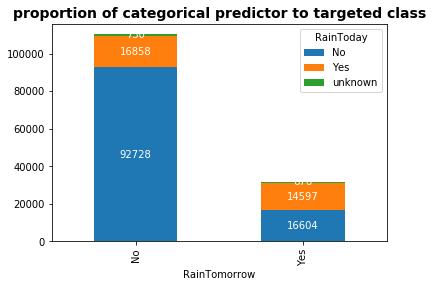

In [174]:
def plotProportion(data):
    ax = categorical.groupby(['RainTomorrow', 'RainToday']).size().unstack().plot(kind='bar', stacked=True)
    for rect in ax.patches:
        height = rect.get_height()
        width = rect.get_width()
        padding = 0.25

        ax.text(rect.get_x() + width - padding, 
                rect.get_y() + height / 2, 
                int(height), 
                ha = 'center', va = 'center',
                color = "white")

plotProportion(categorical)
plt.title("proportion of categorical predictor to targeted class", fontsize = 14, fontweight = "bold")
plt.show()

<h4>Check proportion class target</h4>

Rain 22.0 %
No Rain 78.0 %


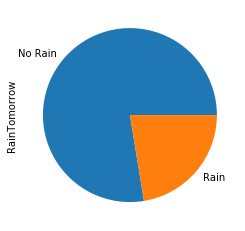

In [175]:
data['RainTomorrow'].value_counts().plot(kind = 'pie', labels = [ 'No Rain','Rain'])
print('Rain', round(data['RainTomorrow'].value_counts()['Yes']/len(data) * 100), '%')
print('No Rain', round(data['RainTomorrow'].value_counts()['No']/len(data) * 100), '%')

<h2>Modelling</h2>

<h2>A. Logistic Regression</h2>

<h3>Model Logit 1 - using original data</h3>

First of all, we need to seperate variable target from variable predictor, create dummy variable for categorical data and split the data into train data and test data. 

In [176]:
cat_columns = data.select_dtypes(['category']).columns
data_new = pd.get_dummies(data, columns = cat_columns, drop_first = True)

In [177]:
data_new.head(2)

,MinTemp,MaxTemp,Rainfall,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,...,WindDir3pm_SSE,WindDir3pm_SSW,WindDir3pm_SW,WindDir3pm_W,WindDir3pm_WNW,WindDir3pm_WSW,WindDir3pm_unknown,RainToday_Yes,RainToday_unknown,RainTomorrow_Yes
0,13.400,22.900,0.600,44.000,20.000,24.000,71.000,22.000,1007.700,1007.100,...,0,0,0,0,1,0,0,0,0,0
1,7.400,25.100,0.000,44.000,4.000,22.000,44.000,25.000,1010.600,1007.800,...,0,0,0,0,0,1,0,0,0,0


In [178]:
#separate predictor and target
X = data_new.drop('RainTomorrow_Yes', axis=1)
y = data_new.RainTomorrow_Yes.values

#setting up testing and training sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("X_train:",X_train.shape)
print("X_test:",X_test.shape)
print("y_train:",y_train.shape)
print("y_test:",y_test.shape)

X_train: (113754, 63)
X_test: (28439, 63)
y_train: (113754,)
y_test: (28439,)


In [179]:
lr = LogisticRegression(multi_class='ovr',solver='liblinear').fit(X_train, y_train)
lr_pred = lr.predict(X_test)

<h4>Accuracy model 1</h4>

In [180]:
print('Accuracy:',accuracy_score(y_test, lr_pred))

Accuracy: 0.83817996413376


Model 1 is model using original data, feature engineering haven't implemented yet in this model. Given accuracy from this model is <b>0.838</b>

<h4>Check summary from model 1</h4>

In [181]:
def fitLogisticRegression(X, y):
    model = sm.Logit(y, sm.add_constant(X))
    result = model.fit()
    return result

model_all = fitLogisticRegression(X_train, y_train)
print(model_all.summary())

Optimization terminated successfully.
         Current function value: inf
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:               113754
Model:                          Logit   Df Residuals:                   113690
Method:                           MLE   Df Model:                           63
Date:                Wed, 03 Jun 2020   Pseudo R-squ.:                     inf
Time:                        11:03:48   Log-Likelihood:                   -inf
converged:                       True   LL-Null:                        0.0000
Covariance Type:            nonrobust   LLR p-value:                     1.000
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  48.8877      1.708     28.624      0.000      45.540      52.235
MinTemp

From the summary above we get the information that there are several variables not significant to predict the targeted variable. It is indicate with <b> p-value > 0.05 </b>. To improve the model, drop unsignificant variables and build second models.

<h3>Feature Engineering</h3>

<h4>Drop unsignificant variables</h4>

In [182]:
X_new = data_new.drop(['Humidity9am','Temp9am','Temp3pm','WindGustDir_ENE','WindGustDir_N','WindGustDir_NNW','WindGustDir_NW',\
                      'WindGustDir_S','WindGustDir_SSW','WindGustDir_W','WindGustDir_WNW','WindGustDir_WSW','WindGustDir_unknown',\
                      'WindDir9am_NNW','WindDir9am_SSW','WindDir9am_SW','WindDir9am_W','WindDir9am_WSW','WindDir9am_unknown',\
                      'WindDir3pm_ENE','WindDir3pm_ESE','WindDir3pm_SE','WindDir3pm_SSE','WindDir3pm_SW','RainTomorrow_Yes'],axis=1)
y_new = data_new.RainTomorrow_Yes.values

<h3>Model Logit 2 - without unsignificant variables</h3>

In [183]:
#setting up testing and training sets
X_train_new, X_test_new, y_train_new, y_test_new = train_test_split(X_new, y_new, test_size=0.2, random_state=42)

In [184]:
lr_new = LogisticRegression(multi_class='ovr',solver='liblinear').fit(X_train_new, y_train_new)
lr_pred_new= lr_new.predict(X_test_new)

In [185]:
print('Accuracy:',accuracy_score(y_test_new, lr_pred_new))

Accuracy: 0.837863497310032


Model 2 is model without unsignificant variables. From the result above we get value of accuracy <b>0.8378</b>

<h3>Model Logit 3 - without outliers and unsignificant variables</h3>

In this third modelling, I implement model Logit using data without outliers and unsignificant variables.

In [186]:
cat_columns_n = data_wo_outliers.select_dtypes(['category']).columns
data_no_out = pd.get_dummies(data_wo_outliers, columns = cat_columns_n, drop_first = True)

In [187]:
X_wo_out = data_no_out.drop(['Humidity9am','Temp9am','Temp3pm','WindGustDir_ENE','WindGustDir_N','WindGustDir_NNW','WindGustDir_NW',\
                      'WindGustDir_S','WindGustDir_SSW','WindGustDir_W','WindGustDir_WNW','WindGustDir_WSW','WindGustDir_unknown',\
                      'WindDir9am_NNW','WindDir9am_SSW','WindDir9am_SW','WindDir9am_W','WindDir9am_WSW','WindDir9am_unknown',\
                      'WindDir3pm_ENE','WindDir3pm_ESE','WindDir3pm_SE','WindDir3pm_SSE','WindDir3pm_SW','RainTomorrow_Yes'],axis=1)
y_wo_out = data_no_out.RainTomorrow_Yes.values

In [188]:
X_train_w, X_test_w, y_train_w, y_test_w = train_test_split(X_wo_out, y_wo_out, test_size=0.2, random_state=42)

In [189]:
lr_wo = LogisticRegression(multi_class='ovr',solver='liblinear').fit(X_train_w, y_train_w)
lr_pred_wo= lr_wo.predict(X_test_w)

In [190]:
print('Accuracy:',accuracy_score(y_test_w, lr_pred_wo))

Accuracy: 0.8607253791339302


From the result above we get the highest accuracy score than the 2 previous models. Given accuracy score from this model is <b>0.861</b>. 

<h3>Assumption Check</h3>

Since from the 3 models above, we got the highest accuracy from model 3, so in this assumption check's step, use the data from model 3. Data from third model is data without outliers and unsignificant variables.

<h4>1. Multicolinearity</h4><br>
Good model can be determined by less or no Multicolinearity.

In [191]:
#gather features
col_dat = data_wo_outliers.drop(['RainTomorrow'],axis=1)
features = "+".join(col_dat.columns)


In [192]:
from sklearn import metrics
from patsy import dmatrices
y, X = dmatrices('RainTomorrow ~' + features, data_wo_outliers, return_type='dataframe')

In [193]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["features"] = X.columns


In [194]:
vif[vif["VIF Factor"]>10]

,VIF Factor,features
0,48076.271,Intercept
52,22.517,MaxTemp
59,20.834,Pressure9am
60,20.871,Pressure3pm
62,18.169,Temp9am
63,22.198,Temp3pm


From the result above, table shown that there are multicolinearity in MaxTemp, Pressure9am, Pressure3pm, Temp9am, and Temp3pm variables. It is indicate that there are strong relationship between those variables. Based on the business case and explanation variable above, we can decided whether we need to remove one of variable or tunning the variables by feature engineering.

<h4>Check correlation between multicolinearity variables</h4>

<Figure size 360x360 with 0 Axes>

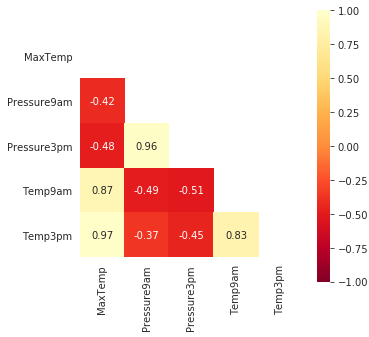

In [195]:
cor_death = data_wo_outliers[['MaxTemp','Pressure9am','Pressure3pm','Temp9am','Temp3pm']]
pd.set_option('precision', 3)
correlation=cor_death.corr(method='pearson')
# heatmap of the correlation 
plt.figure(figsize=(5,5))
mask = np.zeros_like(correlation)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(5, 5))
    ax = sns.heatmap(correlation, mask=mask, square=True,annot=True,vmin=-1,vmax=1,cmap="YlOrRd_r")

Heatmap visualization above shown that Pressure9am and Pressure3pm have high correlation value of 0.96. Temp9am and Temp3pm have correlation value of 0.83, whilst MaxTemp have hingh correlation value in two variables of Temp3pm and Temp9am.<br>
From the business case and variable prediction, we can decide to :<br>
1. Create new predictor variable which contains mean value from Temp9am and Temp3pm, since they explain same information about Temperature value. The difference only in measurement time, the first taken in 9AM and the second taken in 3PM<br>
2. Create new predictor variable which contains mean value from Pressure9am and Pressure3pm, since they explain same information about Pressure value. The difference only in measurement time, the first taken in 9AM and the second taken in 3PM<br>
3. Drop MaxTemp. MaxTemp is maximum temperature in degrees celsius. Usually the maximum temperature occurs during the day, around 9AM-3PM. So, we can decide to drop this variable, because mean value from Temp9am and Temp3pm already contains enough information about temperature to explain.

<h3>Feature Engineering</h3>

<h4>Remove Multicolinearity</h4>

In [196]:
#1. Mean between Temp9am and Temp3pm
data_wo_outliers['Temp'] = (data_wo_outliers.Temp9am + data_wo_outliers.Temp3pm)/2
data_wo_outliers.drop(['Temp9am','Temp3pm'], axis=1, inplace=True)

In [197]:
#2. Mean between Pressure9am and Pressure3pm
data_wo_outliers['Pressure'] = (data_wo_outliers.Pressure9am + data_wo_outliers.Pressure3pm)/2
data_wo_outliers.drop(['Pressure9am','Pressure3pm'], axis=1, inplace=True)

In [198]:
#3. Drop Max temp
data_wo_outliers.drop(['MaxTemp'], axis=1, inplace=True)

<h3>Model Logit 4 - without outliers, unsignificant variables, and multicolinearity</h3>

In [199]:
cat_columns_nw = data_wo_outliers.select_dtypes(['category']).columns
data_no_out2 = pd.get_dummies(data_wo_outliers, columns = cat_columns_nw, drop_first = True)

In [200]:
X_wo_out2 = data_no_out2.drop(['Humidity9am','Pressure','WindGustDir_ENE','WindGustDir_N','WindGustDir_NNW','WindGustDir_NW',\
                      'WindGustDir_S','WindGustDir_SSW','WindGustDir_W','WindGustDir_WNW','WindGustDir_WSW','WindGustDir_unknown',\
                      'WindDir9am_NNW','WindDir9am_SSW','WindDir9am_SW','WindDir9am_W','WindDir9am_WSW','WindDir9am_unknown',\
                      'WindDir3pm_ENE','WindDir3pm_ESE','WindDir3pm_SE','WindDir3pm_SSE','WindDir3pm_SW','RainTomorrow_Yes'],axis=1)
y_wo_out2 = data_no_out2.RainTomorrow_Yes.values

In [201]:
X_train_w2, X_test_w2, y_train_w2, y_test_w2 = train_test_split(X_wo_out2, y_wo_out2, test_size=0.2, random_state=42)

In [202]:
lr_wo2 = LogisticRegression(multi_class='ovr',solver='liblinear').fit(X_train_w2, y_train_w2)
lr_pred_wo2= lr_wo2.predict(X_test_w2)


In [203]:
print('Accuracy:',accuracy_score(y_test_w2, lr_pred_wo2))

Accuracy: 0.8602229124794446


From the last Logit models, we get the accuracy score of <b>0.8602</b>

<h3>Model Logit Comparison</h3>

In [204]:
comparison_logit = {'Model': ['Model Logit 1 - using original data', 'Model Logit 2 - without unsignificant variables', \
                              'Model Logit 3 - without outliers and unsignificant variables','Model Logit 4 - without outliers, unsignificant variables, and multicolinearity'],\
              'Accuracy': [0.8381, 0.8378, 0.8607,0.8602]
              }
pd.DataFrame.from_dict(comparison_logit)

,Model,Accuracy
0,Model Logit 1 - using original data,0.838
1,Model Logit 2 - without unsignificant variables,0.838
2,Model Logit 3 - without outliers and unsignifi...,0.861
3,"Model Logit 4 - without outliers, unsignifican...",0.860


From the four models above, we get the highest accuracy in Model 3 - model using data without outliers and unsignificant variables -, but it has multicolinearity inside. A good model is model tih less/without multicolinearity, so if you want to predict Rain in Australia data using Logistic Regression, I suggest you to using Model Logit 4. 

<h3>Model Logit Interpretation</h3>

After get the best model from Logit, the next step is generate the model summary table and interpret the model coefficients.

In [205]:
def fitLogisticRegression(X, y):
    model = sm.Logit(y, sm.add_constant(X))
    result = model.fit()
    return result

model_final = fitLogisticRegression(X_train_w2, y_train_w2)
print(model_final.summary())

Optimization terminated successfully.
         Current function value: inf
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                87567
Model:                          Logit   Df Residuals:                    87529
Method:                           MLE   Df Model:                           37
Date:                Wed, 03 Jun 2020   Pseudo R-squ.:                     inf
Time:                        11:04:55   Log-Likelihood:                   -inf
converged:                       True   LL-Null:                        0.0000
Covariance Type:            nonrobust   LLR p-value:                     1.000
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 -8.3786      0.108    -77.232      0.000      -8.591      -8.166
MinTemp   

Summary from the model above shown that most of the predictor variable are significant enough to predict target variable. From coefficient value, we get the information that each one-unit change in Rainfall will increase the log odds of tomorrow wil be rain by 0.46.

<h2>B. K-NN (K-Nearest Neighbors)</h2>

<b>K-NN (K-Nearest Neighbors)</b> is supervised machine algorithm that can be used to solve both classification and regression problems. As same as with Logistic Regression models, K-NN have categorical value as targeted variable. The difference is K-NN using distance to classify similar things exist in close proximity. 

In this step, we will classify whether tommorow rain/not with K-NN model, using the data without outliers, unsignificant variables, and multicolinearity.

<h4>Exclude categorical variable from data</h4><br>
K-NN using distance in classification process, so we need to exclude categorical variable and scaling values in each variables.

In [207]:
X_wo_out3 = data_wo_outliers.drop(['WindGustDir','WindDir9am','WindDir3pm','RainToday','RainTomorrow'],axis=1)

In [208]:
X_train_w3, X_test_w3, y_train_w3, y_test_w3 = train_test_split(X_wo_out3, y_wo_out2, test_size=0.2, random_state=42)

<h4>Scaling values from data</h4>

In [210]:
from sklearn import preprocessing
scaler = preprocessing.MinMaxScaler()
scaler.fit(X_wo_out3)
X_wo_out3 = pd.DataFrame(scaler.transform(X_wo_out3), index=X_wo_out3.index, columns=X_wo_out3.columns)

<h4>Create model</h4>

In [212]:
from sklearn.neighbors import KNeighborsClassifier
classifier = KNeighborsClassifier(n_neighbors = 5)
classifier.fit(X_train_w3,y_train_w3)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [213]:
knn_pred = classifier.predict(X_test_w3)


In [214]:
score = accuracy_score(y_test_w3,knn_pred)
print('Accuracy :',score)

Accuracy : 0.8506303672574457


From the result above K-NN model have accuracy value of <b>0.85</b>

<h2>Matrix Evaluation (Recall and Precision)</h2>

After we get the result from our modelling, the next step is evaluate our model using matrix evaluation as follows:<br>
<img src="evalmetric2.png" width="300" /><br>
Where :<br>
`TP (True Positive)` : Predicted positive and the actual's positive <br>
`TN (True Negative)` : Predicted negative and the actual's negative <br>
`FP (False Positive)` : Predicted positive but the actual's negative <br>
`FN (False Negative)` : Predicted negative but the actual's positive <br><br>
From confusion Matrix above we can calculate best evaluation metric for our model: <br>
<b>Recall :</b> Out of all the actual positive classes were predicted correctly.<br>
<b>Precision :</b> Out of all the predicted positive classes were actually positive  

<h3>Logistic Regression Model Logit 4</h3>

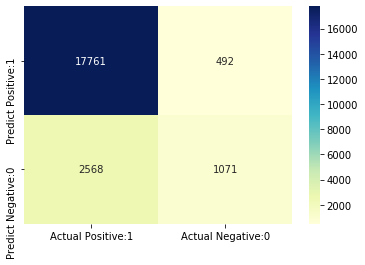

In [215]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test_w2, lr_pred_wo2)

cm_matrix = pd.DataFrame(data=cm, columns=['Actual Positive:1', 'Actual Negative:0'], 
                                 index=['Predict Positive:1', 'Predict Negative:0'])

sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')


In [216]:
TP = cm[0,0]
TN = cm[1,1]
FP = cm[0,1]
FN = cm[1,0]

<h4>Precision</h4>

In [217]:
# print precision score

precision = TP / float(TP + FP)


print('Precision : {}'.format(precision))

Precision : 0.9730455267627239


<h4>Recall</h4>

In [218]:
recall = TP / float(TP + FN)

print('Recall or Sensitivity : {}'.format(recall))

Recall or Sensitivity : 0.8736779969501697


<h3>K-NN (K-Nearest Neighbors)</h3>

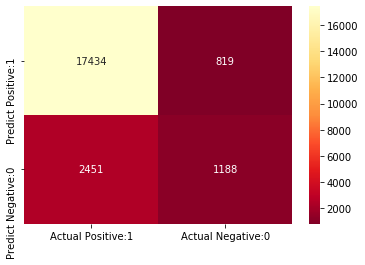

In [219]:
cm_knn = confusion_matrix(y_test_w3, knn_pred)

cm_matrix_knn = pd.DataFrame(data=cm_knn, columns=['Actual Positive:1', 'Actual Negative:0'], 
                                 index=['Predict Positive:1', 'Predict Negative:0'])

sns.heatmap(cm_matrix_knn, annot=True, fmt='d', cmap='YlOrRd_r')

In [220]:
TP_KNN = cm_knn[0,0]
TN_KNN = cm_knn[1,1]
FP_KNN = cm_knn[0,1]
FN_KNN = cm_knn[1,0]

<h4>Precision</h4>

In [221]:
# print precision score

precision_knn = TP_KNN / float(TP_KNN + FP_KNN)


print('Precision : {}'.format(precision_knn))

Precision : 0.9551306634525831


<h4>Recall</h4>

In [222]:
recall_knn = TP_KNN / float(TP_KNN + FN_KNN)

print('Recall or Sensitivity : {}'.format(recall_knn))

Recall or Sensitivity : 0.8767412622579834


<h2>Model Comparison</h2>

In [224]:
comparison = {'Model': ['Logistic Regression', 'K-Nearest Neighbor'],\
              'Accuracy': [0.86,0.85],\
              'Precision':[0.97,0.955],\
              'Recall':[0.87,0.8767]}
pd.DataFrame.from_dict(comparison)

,Model,Accuracy,Precision,Recall
0,Logistic Regression,0.860,0.970,0.870
1,K-Nearest Neighbor,0.850,0.955,0.877


<h2>Conclusion</h2>

From the result above, we can conclude that :<br>
1. Remove outliers, unsignificant variables, and multicolinearity can improve accuracy from the model.<br>
2. From the above models in Logistic Regression, Model-4 (without outliers, unsignificant variables, and multicolinearity) is the best model<br>
3. The increasing amount of Rainfall will increase probability of tomorrow wil be rain.
4. Both models either Logistic Regression and K-Nearest Neighbor have high value in metrics evaluation, it's mean that you can consider to choose one of these models to predict Rain Australia data.